In [1]:
from cuml.manifold import UMAP as UMAP
from cuml.dask.manifold import UMAP as UMAP_MNMG

from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import dask.array as da

from sklearn.datasets import make_blobs
from cuml.metrics import trustworthiness
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def benchmark(args):
    # Generate dataset
    X, y = make_blobs(n_samples=args['number_samples'], n_features=args['input_dimension'],
                      centers=args['centers'])
    
     # Warm up (used to prevent statistical anomalies in time measurement due to first time initialization)
    model = UMAP(n_components=args['output_dimension'], random_state=args['random_state'],
                 n_neighbors=args['n_neighbors'])
    model.fit_transform(X)
    
    durations = []
    trust_scores = []
    for i in range(args['n_iter']):
        # Instantiate local UMAP model
        model = UMAP(n_components=args['output_dimension'], random_state=args['random_state'],
                     n_neighbors=args['n_neighbors'])
        
        # Perform transformation and measure time
        start = time.time()
        transformed = model.fit_transform(X)
        durations.append(time.time()-start)
        
        # Compute trustworthiness score
        trust_scores.append(trustworthiness(X, transformed, n_neighbors=args['n_neighbors']))
        
    durations = np.array(durations)
    trust_scores = np.array(trust_scores)
    
    # Compute runtime average and variance as well as trustworthiness score average
    umap_cuml_scores = durations.mean(), durations.var(), trust_scores.mean()
    
    if args['benchmark_verbose']:
        duration_mean, duration_var, trust = umap_cuml_scores
        print("\t\tCUML UMAP: duration avg - var: {:.2f} - {:.2f}, tustworthiness: {:.2f}".format(duration_mean, duration_var, trust))
    
    return umap_cuml_scores

In [3]:
def mnmg_benchmark(args):
    # Generate dataset
    X, y = make_blobs(n_samples=args['number_samples'], n_features=args['input_dimension'],
                      centers=args['centers'])
    
    # Number of samples per partition
    n_sampling = int(args['number_samples'] * args['sampling_ratio'])
    
    # Generate local train data
    selection = np.random.choice(args['number_samples'], n_sampling)
    lX = X[selection]
    
    # Number of samples per partition
    n_samples_per_part = int(args['number_samples'] / args['n_parts'])
    
    # Generate partitioning of distributed data for inference
    chunks = [n_samples_per_part] * args['n_parts']
    chunks[-1] += args['number_samples'] % n_samples_per_part
    chunks = tuple(chunks)
    dX = da.from_array(X, chunks=(chunks, -1))

    # Warm up (used to prevent statistical anomalies in time measurement due to first time initialization)
    local_model = UMAP(n_components=args['output_dimension'], random_state=args['random_state'],
                       n_neighbors=args['n_neighbors'])
    local_model.fit(lX)
    model = UMAP_MNMG(local_model)
    model.transform(dX).compute()
    
    durations = []
    trust_scores = []
    for i in range(args['n_iter']):
        
        # Train local model
        local_model = UMAP(n_components=args['output_dimension'], random_state=args['random_state'],
                           n_neighbors=args['n_neighbors'])
        local_model.fit(lX)
        
        # Pass trained model and order distributed inference
        model = UMAP_MNMG(local_model)
        lazy_transformed = model.transform(dX)
        
        # Perform distributed inference and measure time
        start = time.time()
        transformed = lazy_transformed.compute()
        durations.append(time.time()-start)
        
        # Compute trustworthiness score
        trust_scores.append(trustworthiness(X, transformed, n_neighbors=args['n_neighbors']))
        
    durations = np.array(durations)
    trust_scores = np.array(trust_scores)
    
    # Compute runtime average and variance as well as trustworthiness score average
    umap_cuml_mnmg_scores = durations.mean(), durations.var(), trust_scores.mean()
    
    if args['benchmark_verbose']:
        duration_mean, duration_var, trust = umap_cuml_mnmg_scores
        print("\t\tCUML UMAP: duration avg - var: {:.2f} - {:.2f}, tustworthiness: {:.2f}".format(duration_mean, duration_var, trust))
    
    return umap_cuml_mnmg_scores

In [4]:
def perform_benchmark(args, variable):
    if args['benchmark_verbose']:
        MNMG_msg = 'with MNMG enabled' if args['MNMG'] else ''
        print("Runtime performance as a function of number of {} {}:".format(variable['variable'], MNMG_msg))
       
    if args['MNMG']:
        cluster = LocalCUDACluster(n_workers=8, threads_per_worker=1)
        client = Client(cluster)

    runtimes = []
    for val in variable['values']:
        if args['benchmark_verbose']:
            print("\n\tWith {}={} :".format(variable['variable'], val))
        args[variable['variable']] = int(val)
        if args['MNMG']:
            mean_runtime = mnmg_benchmark(args)[0]
        else:
            mean_runtime = benchmark(args)[0]
        runtimes.append(mean_runtime)
    runtimes = np.array(runtimes)
    
    if args['MNMG']:
        client.close()

    fig, ax = plt.subplots()
    ax.plot(variable['values'], runtimes)

    ax.set_title(variable['variable'])
    ax.set_ylabel("runtime", rotation=0, size='large', labelpad=45)

    plt.show()

In [5]:
import warnings
warnings.filterwarnings('ignore')

args = { 'random_state': None, 'centers': 42, 'n_neighbors': 10, 'n_iter': 3,
         'sampling_ratio':0.1, 'n_parts': 8, 'MNMG': False,
         'benchmark_verbose': False}

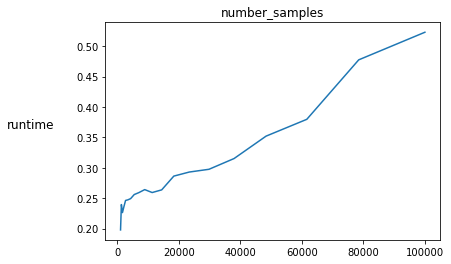

In [6]:
args['random_state'] = None
args['input_dimension'] = 10
args['output_dimension'] = 2
variable = {'variable': 'number_samples', 'values': np.logspace(start=3, stop=5, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

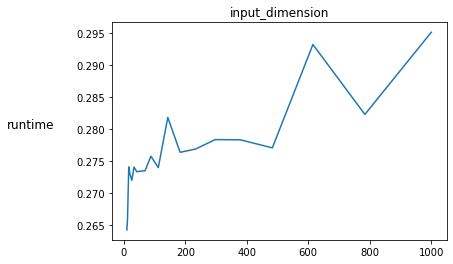

In [7]:
args['random_state'] = None
args['number_samples'] = 10000
args['output_dimension'] = 2
variable = {'variable': 'input_dimension', 'values': np.logspace(start=1, stop=3, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

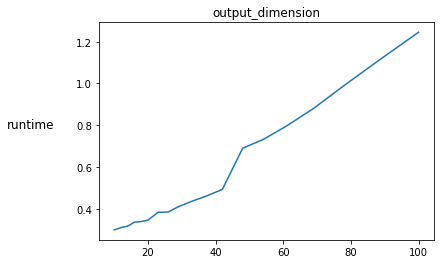

In [8]:
args['random_state'] = None
args['number_samples'] = 10000
args['input_dimension'] = 10
variable = {'variable': 'output_dimension', 'values': np.logspace(start=1, stop=2, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

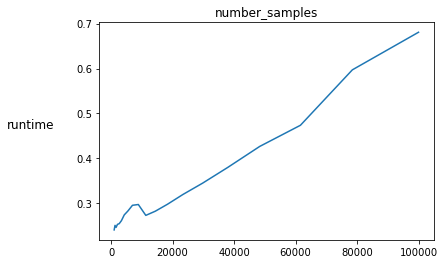

In [9]:
args['random_state'] = 42
args['input_dimension'] = 10
args['output_dimension'] = 2
variable = {'variable': 'number_samples', 'values': np.logspace(start=3, stop=5, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

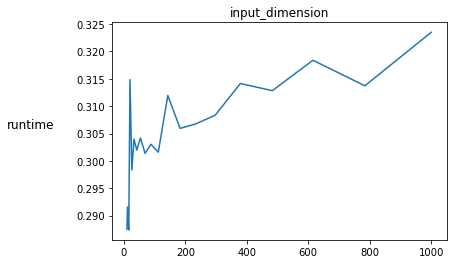

In [10]:
args['random_state'] = 42
args['number_samples'] = 10000
args['output_dimension'] = 2
variable = {'variable': 'input_dimension', 'values': np.logspace(start=1, stop=3, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

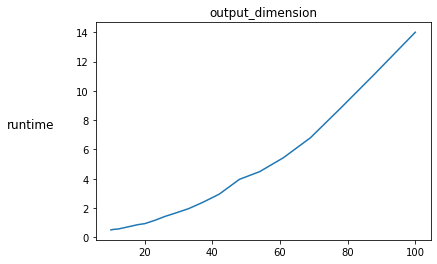

In [11]:
args['random_state'] = 42
args['number_samples'] = 10000
args['input_dimension'] = 200
variable = {'variable': 'output_dimension', 'values': np.logspace(start=1, stop=2, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

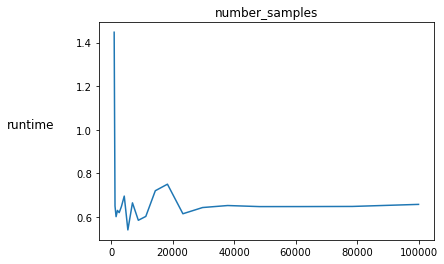

In [12]:
args['MNMG'] = True
args['input_dimension'] = 10
args['output_dimension'] = 2
variable = {'variable': 'number_samples', 'values': np.logspace(start=3, stop=5, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

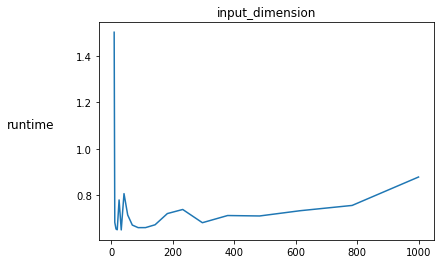

In [13]:
args['MNMG'] = True
args['number_samples'] = 10000
args['output_dimension'] = 2
variable = {'variable': 'input_dimension', 'values': np.logspace(start=1, stop=3, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)

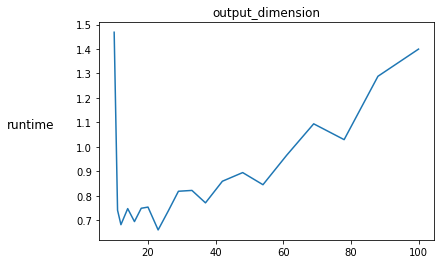

In [14]:
args['MNMG'] = True
args['number_samples'] = 10000
args['input_dimension'] = 200
variable = {'variable': 'output_dimension', 'values': np.logspace(start=1, stop=2, num=20, base=10.0, dtype='int')}
perform_benchmark(args, variable)